# PLOT SST DIAGS

In [1]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.pyplot as plt
import numpy as N
import xskillscore as xs
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates


### First read croco grid

In [2]:
#read grid
ds_grid=xr.open_dataset('/home/shom_simuref/CROCO/ODC/CONFIGS/MEDITERRANEE_GLOBALE/CROCO_FILES/test2.nc')
coord_dict={"xi_rho":"X","eta_rho":"Y","xi_u":"X_U","eta_v":"Y_V"}
ds_grid=ds_grid.assign_coords({"X":ds_grid.lon_rho[0,:], "Y":ds_grid.lat_rho[:,0]})
ds_grid=ds_grid.swap_dims(coord_dict)
mask=ds_grid.mask_rho

### Read Croco's stats and fitting

In [3]:
#data directory
stat_dir='/home/shom_simuref/CROCO/ODC/POSTPROC/SST/'

In [4]:
#read mean sst
ds=xr.open_dataset(f'{stat_dir}/mean_sst_croco.nc')
sst_croco=ds.temp.isel(time=slice(0,-1))

In [5]:
sst_croco=sst_croco.where(mask==1)

In [6]:
#get start and end date
date_start=sst_croco.start_date
date_end=sst_croco.end_date
print(date_start,date_end)

2012-06-01 2013-08-01


In [7]:
#read result of fitting
ds2=xr.open_dataset(f'{stat_dir}/sst_fit_croco.nc')
sst_fit_croco=ds2.curvefit_coefficients

### read sevivi's stats and fitting

In [8]:
#read mean sst
ds_sevi=xr.open_dataset(f'{stat_dir}/mean_sst_sevi.nc')

In [9]:
sst_sevi=ds_sevi.sea_surface_temperature

In [10]:
#read seviri fitting
ds_sevi2=xr.open_dataset(f'{stat_dir}/sst_fit_sevi.nc')


In [11]:
sst_fit_sevi=ds_sevi2.curvefit_coefficients

### interp croco on seviri grid

In [12]:
mask_sevi=mask.interp(X=sst_sevi.lon,Y=sst_sevi.lat)

In [13]:
sst_croco2=sst_croco.interp(X=sst_sevi.lon,Y=sst_sevi.lat)

### define a function that convert phase in days

In [14]:
def convert_phase(phase):
    phase=phase/(2*N.pi)*365
    arr=phase.data
    #arr=N.mod(arr,365)
    #arr[arr>365]-=365
    #phase[:]=arr[:]-365.
    print(phase.min(),phase.max())
    return phase

### calcul the phase of Croco and Seviri

In [15]:
phase_croco=sst_fit_croco.sel(param="b")
phase_croco2=convert_phase(phase_croco)
#print(phase_croco2.min(),phase_croco2.max())

<xarray.DataArray 'curvefit_coefficients' ()>
array(9.93157056)
Coordinates:
    param    <U1 'b' <xarray.DataArray 'curvefit_coefficients' ()>
array(67.59008913)
Coordinates:
    param    <U1 'b'


In [16]:
phase_sevi=sst_fit_sevi.sel(param="b")
phase_sevi2=convert_phase(phase_sevi)
#print(phase_sevi2.min(),phase_sevi2.max())

<xarray.DataArray 'curvefit_coefficients' ()>
array(1.95352458)
Coordinates:
    param    <U1 'b' <xarray.DataArray 'curvefit_coefficients' ()>
array(55.65159782)
Coordinates:
    param    <U1 'b'


## Fitting PLOT

In [17]:
proj=ccrs.LambertConformal(central_latitude=38,central_longitude=15)
lon_croco=sst_croco.X
lat_croco=sst_croco.Y
lon_sevi=sst_sevi.lon
lat_sevi=sst_sevi.lat

In [18]:
bounds=dict(a=(3,7),b=(0,70),c=(17,22))
names=dict(a="Amplitude",b="Phase",c="Intercept")
clab=["°c","days","°c"]
cmap=dict(a=plt.cm.jet,b=plt.cm.rainbow,c=plt.cm.plasma)
data_croco=dict(a=sst_fit_croco.sel(param="a"),b=phase_croco2,c=sst_fit_croco.sel(param="c"))
data_sevi=dict(a=sst_fit_sevi.sel(param="a"),b=phase_sevi2,c=sst_fit_sevi.sel(param="c"))

In [19]:
#do the plot

In [20]:
def plot_data(data,lon,lat,ax,name,model,clab,**kw_plot):
    kwargs_plot=dict(transform=ccrs.PlateCarree())
    kwargs_plot.update(kw_plot)
    ax.set_extent([-7,36,30,45],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
    ax.set_title(f'{name} SST {model}')
    cf=ax.pcolormesh(lon,lat,data,**kwargs_plot)
    cbar = fig.colorbar(cf, ax=ax, shrink=0.7)
    cbar.set_label(clab)
    return fig,cbar

a
b
c


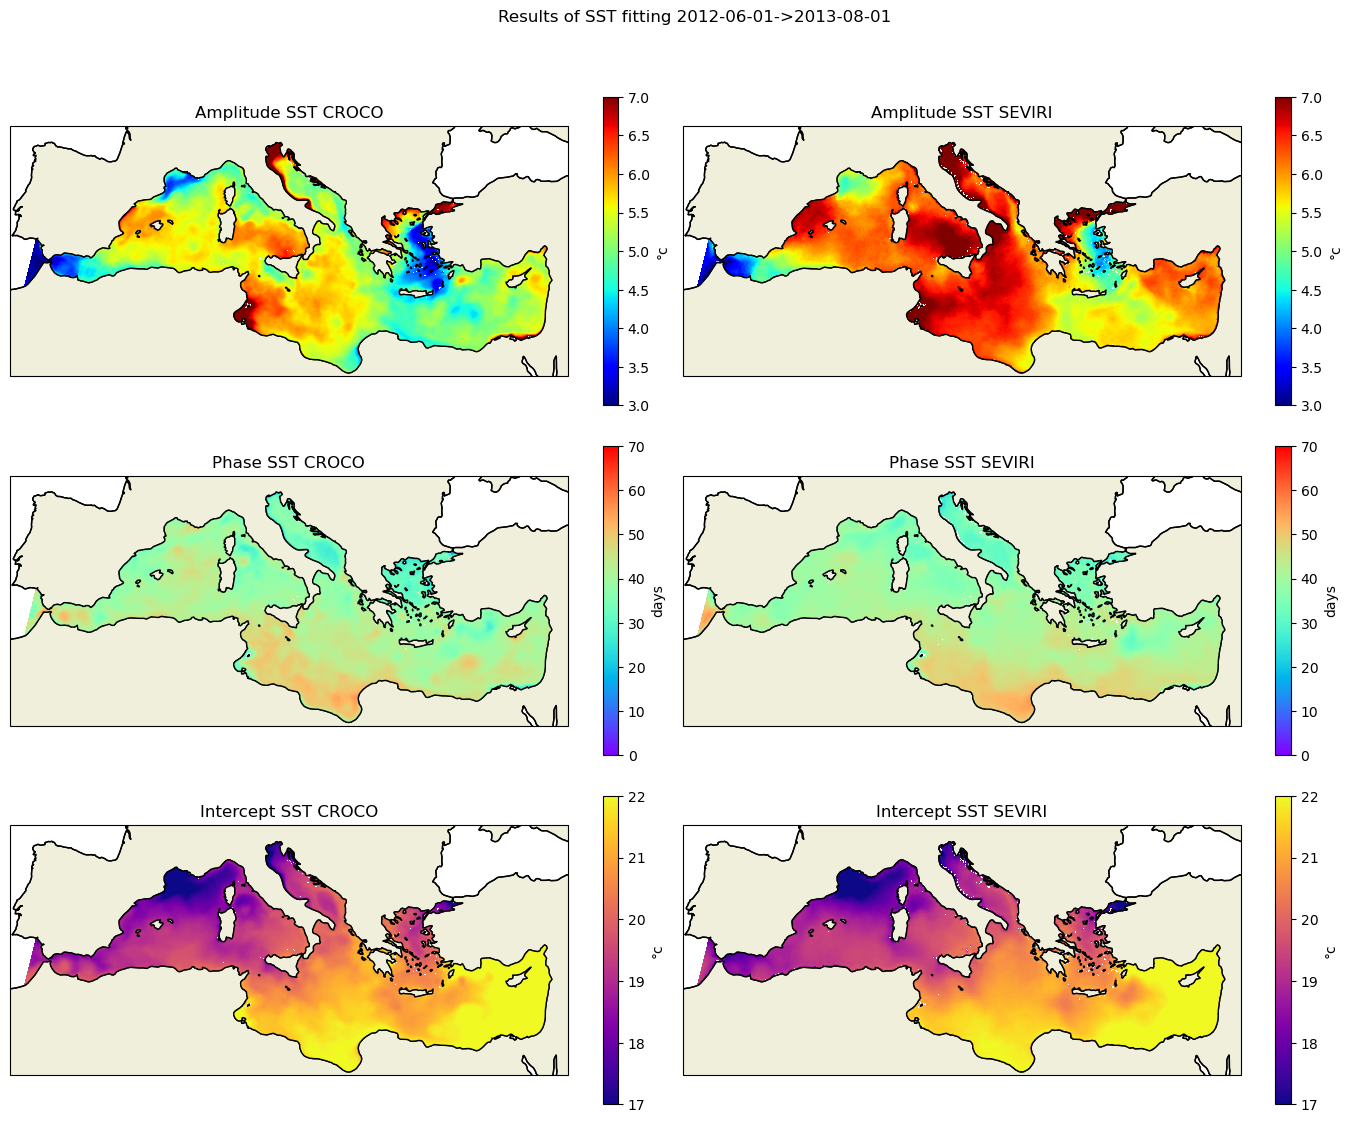

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12),subplot_kw=dict(projection=proj))
plt.suptitle(f'Results of SST fitting {date_start}->{date_end}')
for i,param in enumerate(("a","b","c")):
   print(param)
   data1=data_croco[param].where(mask==1) 
   data2=data_sevi[param].where(mask_sevi==1)
   vmin,vmax=bounds[param]
   kw_plot=dict(vmin=vmin,vmax=vmax,cmap=cmap[param])
   fig,cbar=plot_data(data1,lon_croco,lat_croco,axes[i,0],names[param],"CROCO",clab[i],**kw_plot)
   fig,cbar=plot_data(data2,lon_sevi,lat_sevi,axes[i,1],names[param],"SEVIRI",clab[i],**kw_plot)
   plt.tight_layout()
plt.savefig('sst_fitting.png')

## monthly diff

In [22]:
def plot_data2(data,lon,lat,ax,title,**kw_plot):
    kwargs_plot=dict(transform=ccrs.PlateCarree())
    kwargs_plot.update(kw_plot)
    ax.set_extent([-7,36,30,45],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
    ax.set_title(title)
    cf=ax.pcolormesh(lon,lat,data,**kwargs_plot)
    #cbar = fig.colorbar(cf, ax=ax, shrink=0.7)
    return cf,ax

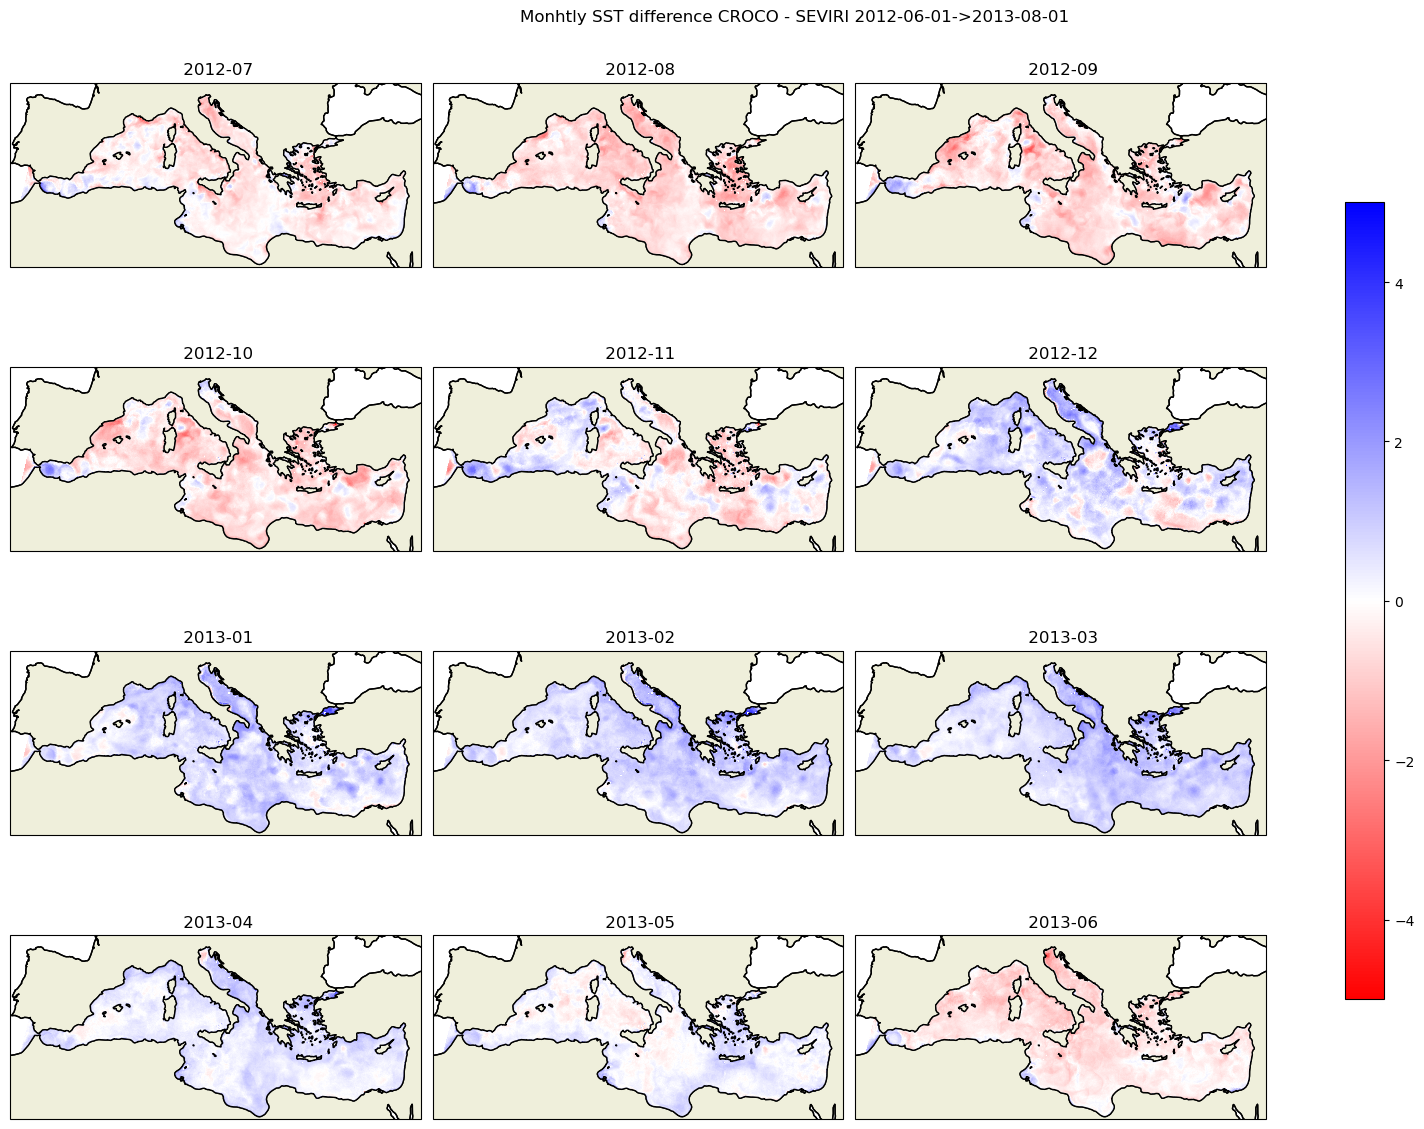

In [23]:
months=sst_sevi.time.dt.month
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12),subplot_kw=dict(projection=proj))
kw_plot=dict(vmin=-5,vmax=5,cmap=plt.cm.bwr_r)
dates=sst_croco2.time.dt.strftime('%Y-%m')
plt.suptitle(f'Monhtly SST difference CROCO - SEVIRI {date_start}->{date_end}')
for i in range(12):
    date=dates[i].data
    #print(date)
    data1=sst_croco2.isel(time=i).where(mask_sevi==1)
    data2=sst_sevi.isel(time=i).where(mask_sevi==1)
    diff=data1-data2
    #print(diff.min().data,diff.max().data)
    title=f' {date}'
    cf,ax=plot_data2(diff,lon_sevi,lat_sevi,axes.flatten()[i],title,**kw_plot)
plt.tight_layout()
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.7)
plt.savefig('sst_monthly_diff_croco_seviri.png')

## Extrema plots

In [24]:
#read data

In [25]:
def plot_data3(data,lon,lat,ax,title,**kw_plot):
    kwargs_plot=dict(transform=ccrs.PlateCarree())
    kwargs_plot.update(kw_plot)
    ax.set_extent([-7,36,30,45],crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
    ax.set_title(title)
    cf=ax.pcolormesh(lon,lat,data,**kwargs_plot)
    cbar = fig.colorbar(cf, ax=ax, shrink=0.4,label='°c')
    return cf,ax

In [26]:
ds_croco_p95=xr.open_dataset(f'{stat_dir}/sst_percentile_95.nc')
sst_croco_p95=ds_croco_p95.temp
sst_croco_p95=sst_croco_p95.where(mask==1)

In [27]:
ds_croco_p5=xr.open_dataset(f'{stat_dir}/sst_percentile_5.nc')
sst_croco_p5=ds_croco_p5.temp
sst_croco_p5=sst_croco_p5.where(mask==1)

In [28]:
ds_sevi_p95=xr.open_dataset(f'{stat_dir}/sst_sevi_p95.nc')
sst_sevi_p95=ds_sevi_p95.sea_surface_temperature.where(mask_sevi==1)

In [29]:
ds_sevi_p5=xr.open_dataset(f'{stat_dir}/sst_sevi_p5.nc')
sst_sevi_p5=ds_sevi_p5.sea_surface_temperature.where(mask_sevi==1)

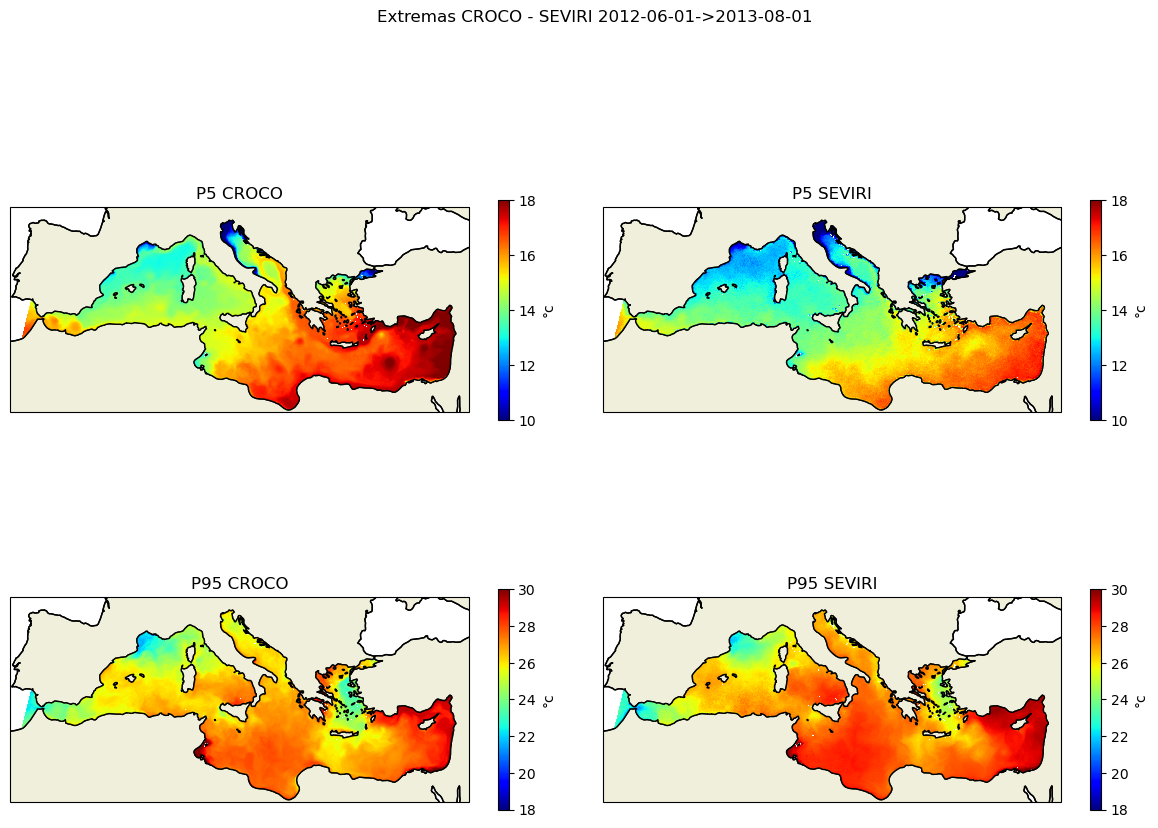

In [30]:
kw_plot=dict(vmin=10,vmax=18,cmap=plt.cm.jet)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10),subplot_kw=dict(projection=proj))
plt.suptitle(f'Extremas CROCO - SEVIRI {date_start}->{date_end}')

title=f'P5 CROCO'
cf,ax=plot_data3(sst_croco_p5,lon_croco,lat_croco,axes[0,0],title,**kw_plot)
title=f'P5 SEVIRI'
cf,ax=plot_data3(sst_sevi_p5,lon_sevi,lat_sevi,axes[0,1],title,**kw_plot)

kw_plot=dict(vmin=18,vmax=30,cmap=plt.cm.jet)

title=f'P95 CROCO'
cf,ax=plot_data3(sst_croco_p95,lon_croco,lat_croco,axes[1,0],title,**kw_plot)
title=f'P95 SEVIRI'
cf,ax=plot_data3(sst_sevi_p95,lon_sevi,lat_sevi,axes[1,1],title,**kw_plot)

plt.tight_layout()
plt.savefig('sst_stats_croco_seviri.png')

### RMSE PLOT

In [31]:
ds_rmse=xr.open_dataset(f'{stat_dir}/rmse_croco_sevi_annual.nc')

In [32]:
rmse=ds_rmse.rmse.where(mask_sevi==1)

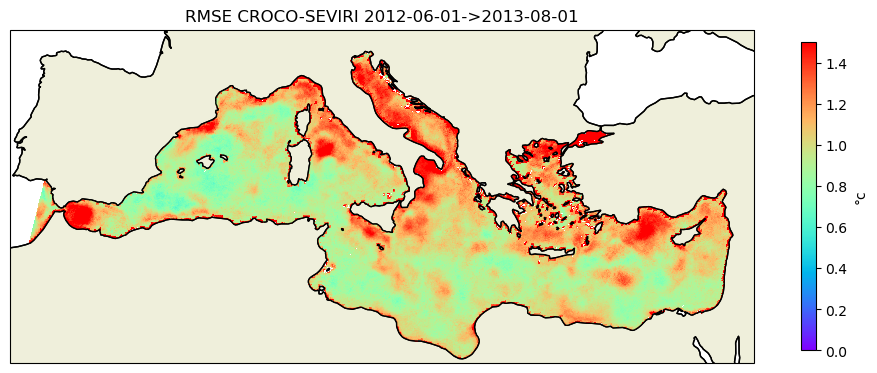

In [33]:
kw_plot=dict(vmin=0,vmax=1.5,cmap=plt.cm.rainbow)
title=f"RMSE CROCO-SEVIRI {date_start}->{date_end}"
fig, axes = plt.subplots(1,1,figsize=(12, 10),subplot_kw=dict(projection=proj))
cf,ax=plot_data3(rmse,lon_sevi,lat_sevi,axes,title,**kw_plot)
plt.savefig('rmse_croco_seviri.png')

In [34]:
ds_rmse2=xr.open_dataset(f'{stat_dir}/rmse_croco_sevi_monthly.nc')

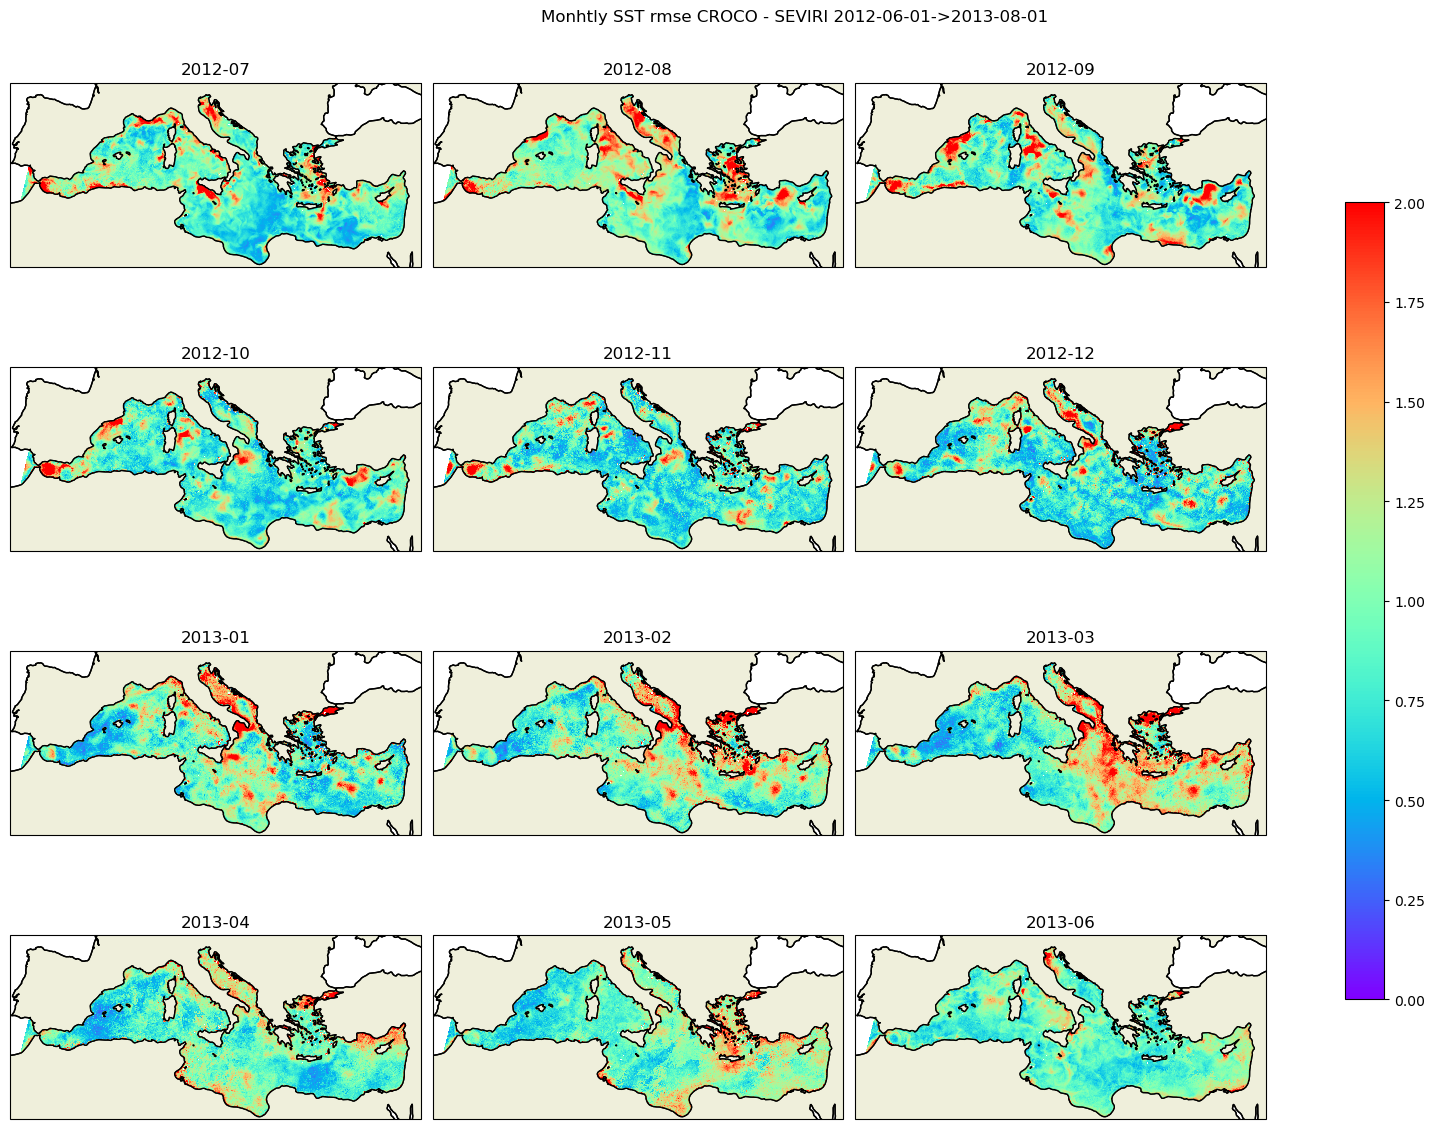

In [35]:
months=ds_rmse2.time.dt.month
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12),subplot_kw=dict(projection=proj))
plt.suptitle(f'Monhtly SST rmse CROCO - SEVIRI {date_start}->{date_end}')

kw_plot=dict(vmin=0,vmax=2.0,cmap=plt.cm.rainbow)
dates=ds_rmse2.time.dt.strftime('%Y-%m')
for i in range(12):
    date=dates[i].data
    data=ds_rmse2.rmse.isel(time=i).where(mask_sevi==1)
    title=f'{date}'
    cf,ax=plot_data2(data,lon_sevi,lat_sevi,axes.flatten()[i],title,**kw_plot)
plt.tight_layout()
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.7)
plt.savefig('sst_monthly_rmse_croco_seviri.png')

## SST BY BASINS

In [36]:
import geopandas as gpd
import shapely.vectorized

basins_shp='/home/shom_simuref/CROCO/ODC/POSTPROC/DATA/shapefiles/med_sub_basins_2.shp'
gdf=gpd.read_file(basins_shp)
gdf=gdf.set_index('name')
basins_names=gdf.index

### read daily data

In [37]:
daily_sevi=xr.open_dataset(f'{stat_dir}/mean_daily_sst_sevi.nc')
daily_croco=xr.open_dataset(f'{stat_dir}/mean_daily_sst_croco.nc')

In [38]:
lon_sevi2D,lat_sevi2D=N.meshgrid(lon_sevi,lat_sevi)
lon_croco2D,lat_croco2D=N.meshgrid(lon_croco,lat_croco)

In [39]:
name='Levantine Sea'
#select masks of interest
area=gdf.loc[gdf.index==name]
mask_seviri=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_sevi2D.data,lat_sevi2D.data)
mask_croco=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_croco2D.data,lat_croco2D.data)

In [40]:
sst_seviri_area=daily_sevi.sea_surface_temperature.where(mask_seviri)
sst_croco_area=daily_croco.temp.where(mask_croco)

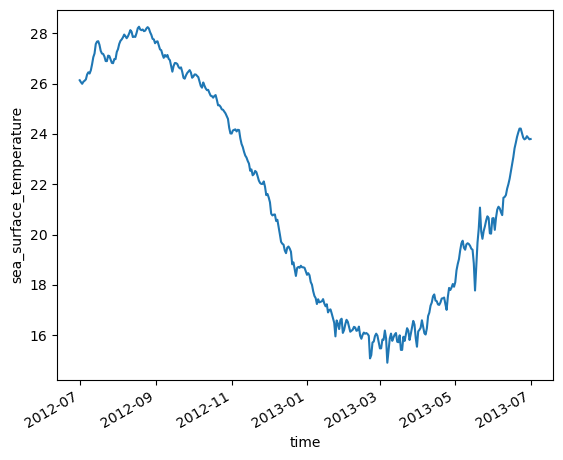

In [41]:
sst_seviri_area.mean(dim=["lat","lon"]).plot()

In [42]:
def format_date(ax):
    return ax.xaxis.set_major_formatter(
           mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

In [49]:
sst_daily_croco=daily_croco.temp
sst_daily_sevi=daily_sevi.sea_surface_temperature

In [59]:
sst_daily_croco=sst_daily_croco.where(sst_daily_croco>0)

In [52]:
sst_daily_sevi=sst_daily_sevi.where(sst_daily_sevi>0)

In [62]:
def plot_all(aviso,croco):
    basins_names2=basins_names.tolist()[:]
    #fig, axes = plt.subplots(nrows=len(basins_names2), sharex=True,sharey=False,ncols=1, figsize=(12, 12))
    fig, axes = plt.subplots(nrows=5,ncols=2, sharex=True,sharey=False, figsize=(12, 12))

    for i,name in enumerate(basins_names2):
        print(i,name)
        
        #select area of interest
        area=gdf.loc[gdf.index==name]
        
        #get the mask from longitude and latitude : intersection of area and the domain
        mask_aviso=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_sevi2D,lat_sevi2D)
        mask_croco=shapely.vectorized.contains(area.dissolve().geometry.item(),lon_croco2D,lat_croco2D)
        
        #apply the mask to the data and do an average over the horizontal grid
        eke_aviso_area=aviso.where(mask_aviso).mean(dim=["lat","lon"])
        eke_croco_area=croco.where(mask_croco).mean(dim=["Y","X"])
        #ax=axes[i]
        ax=axes.flatten()[i]
        #do the plot
        ax.plot(eke_aviso_area.time,eke_aviso_area.data,label="Seviri")
        ax.plot(eke_croco_area.time,eke_croco_area.data,label="Croco")
        
        ### custom labels ###
        plt.xlabel('');plt.ylabel('')
        #get min,max to set clean limits
        min1,max1=eke_aviso_area.min(),eke_aviso_area.max()
        min2,max2=eke_croco_area.min(),eke_croco_area.max()
        
        ax.legend()
        ax.set_ylabel('$^°C$')
        ax.set_title('%s'%(name))
        ax.set_ylim((min(min1,min2),max(max1,max2)))
        ax.yaxis.set_minor_locator(MaxNLocator(1))
        if i==len(basins_names2)-1: 
            ax=format_date(ax)
    plt.suptitle(f'Evolution of daily mean SST')
    plt.tight_layout()
    return fig

0 Strait of Gibraltar
1 Alboran Sea
2 Ionian Sea
3 Tyrrhenian Sea
4 Adriatic Sea
5 Levantine Sea
6 Aegean Sea
7 Balearic Sea
8 South-Western Basin
9 North-Western Basin


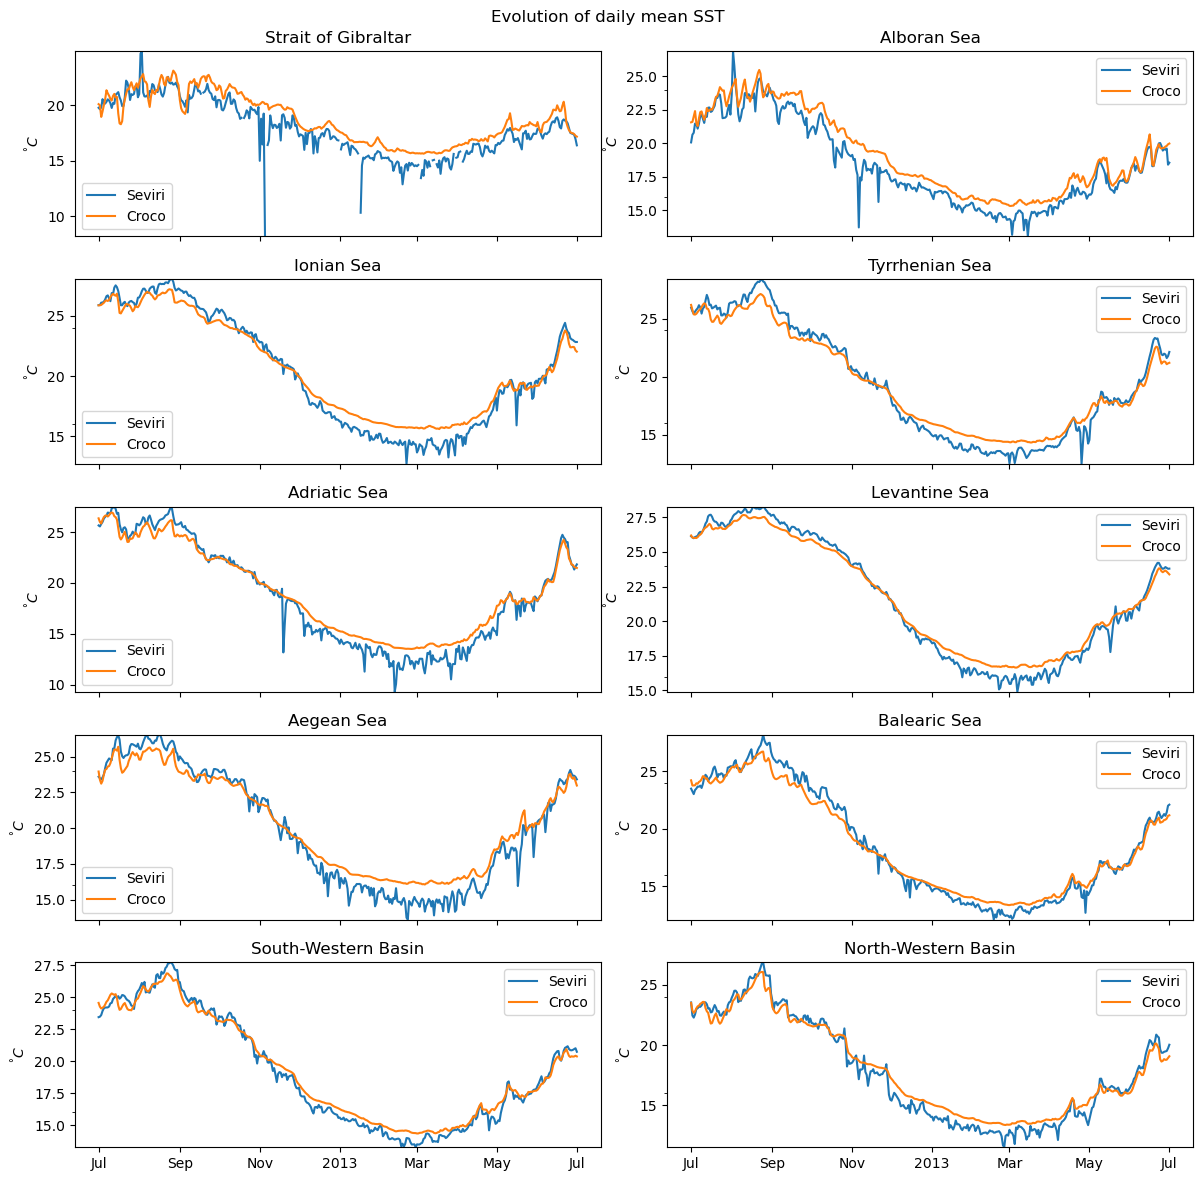

In [63]:
fig_sst_basins=plot_all(sst_daily_sevi,sst_daily_croco)
fig_sst_basins.savefig('sst_daily_mean_basins.png',)